In [42]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier,RidgeClassifier
from itertools import compress
from sklearn.feature_selection import RFECV

In [2]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']

In [54]:
X_ftr=pd.read_csv('ftr_train.csv')
X_ftr.drop('Unnamed: 0',inplace=True,axis=1)

In [3]:
# Фуникция считает качество модели на кроссвалилации
# clf - модель, X,y - данные, ftr_set - пподмножество названий колонок, на которых считаем модель
# cv_val - количество холдов для кросс валидации
def CV_score(clf,X,y,ftr_set,cv_val):
    # Если подмоножество признаков пустое, то возвращаем 0 
    if len(ftr_set)==0:
        return 0
    # Иначе делаем кроссвалидацию
    scores = cross_val_score(clf, X[ftr_set],y,cv=cv_val)
    return scores.mean()
    #return random.random()

# Функция определяет  фичу, добавление которой наилучшим образом увеличивает качество 
# Фуникция берет случайную фичу из диапазона, добавляет её к стартовому набору фич и строит качество
# N -  максимальное количество итераций
# start_ftr - стартовый набор признаков
# start_cv - стартовое значение качества
def get_best_ftr(clf,X,y,start_ftr,start_cv,cv_val,N_params):
    print ("===START ftr lookup")
    print ("Start_ftr_set=",start_ftr)
    print ("Start_cv=     ",start_cv)
    i=0
    max_iter=N_params[0]
    start_ftr_N=N_params[1]
    end_ftr_N=N_params[2]
    used_ftr=start_ftr.copy()
    best_cv=start_cv
    best_ftr=''
    feature_names=list(X.columns)
    #while i<max_iter:
    for ftr_index in range(max_iter):
        # выбираем случайную фичу
        #ftr_index=random.randint(start_ftr_N,end_ftr_N)
        ftr_name=feature_names[ftr_index]
        # Проверяем, что её не использвоали
        if ftr_name in used_ftr:
            continue
        # Считаем качество на наборе фич с учетом выбранной
        ftr_set=start_ftr.copy()
        ftr_set.append(ftr_name)
        cv=CV_score(clf,X,y,ftr_set,cv_val)
        if cv>best_cv:
            best_cv=cv
            best_ftr=ftr_name
            print ("  ! ",end='')
        else:
            print ("    ",end='')
        print ("{:5} {:10}".format(i,ftr_name), " ",cv)
        used_ftr.append(ftr_name)
        i=i+1
    print ("===END ftr lookup ")
    return best_ftr,best_cv

# Фуникция производит отбор фич методом Sequential Feature Selection
def sfs(clf,X,y,start_ftr,cv_val,N_params):
    cur_ftr=start_ftr.copy()
    best_cv=CV_score(clf,X,y,start_ftr,cv_val)
    doAdd=True
    while doAdd:
        new_ftr,best_cv=get_best_ftr(clf,X,y,cur_ftr,best_cv,cv_val,N_params)
        if (new_ftr!=''):
            print (new_ftr+" added! New cv=",best_cv)
            cur_ftr.append(new_ftr)
        else: doAdd=False
    print ("Final_ftr_set=",cur_ftr, " final_cv=",best_cv)
    return cur_ftr,best_cv

In [9]:
clf = RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
start_ftr=['f138', 'f96', 'f76', 'f11', 'f185', 'f115', 'f131', 'f83']
start_ftr=['f11', 'f12', 'f22', 'f79', 'f82', 'f96', 'f133', 'f138', 'f143','f147', 'f152', 'f156', 'f182', 'f187', 'f200']
#clf=SGDClassifier(random_state=42,alpha=0.001,loss='log',penalty='l1')
#start_ftr=[]
max_iter=223
start_ftr_N=0
end_ftr_N=223
N_params=(max_iter, start_ftr_N,end_ftr_N)
best_ftr,best_cv=sfs(clf,X,y,start_ftr,5,N_params)

===START ftr lookup
Start_ftr_set= ['f138', 'f96', 'f76', 'f11', 'f185', 'f115', 'f131', 'f83']
Start_cv=      0.494979310735
  !     0 f0           0.501569585072
        1 f1           0.47605209385
        2 f2           0.470621880365
  !     3 f3           0.501854084894
        4 f4           0.495259676065
        5 f5           0.464848503754
        6 f6           0.492116003781
        7 f7           0.470893248643
        8 f8           0.493547865168
        9 f9           0.485517122344
       10 f10          0.498415665953
       11 f12          0.474617328933
       12 f13          0.458003352115
       13 f14          0.466676022789
       14 f15          0.496127913833
       15 f16          0.500421391907
       16 f17          0.426688141122
       17 f18          0.481792966734
       18 f19          0.495838092105
       19 f20          0.49698299415
       20 f21          0.501282642207
       21 f22          0.500994466039
       22 f23          0.491833985843
  

# ADD-DEL

In [58]:
# Вычисляем качество
def get_cv_score(clf,X,y,cur_set):
    if len(cur_set)==0:
        return 0
    scores = cross_val_score(clf, X[cur_set],y,cv=5)
    return scores.mean()

# Вспомогательная фуникция для ADD шага
# Определяем признак, добавление которого в набор приводит к лучшему изменению качества
# clf - модель
# ftr_set- текущий набор признаков
# cols - набор признаков для добавления
def add_one_step(clf,X,y,ftr_set,cols):
    cv_df=pd.DataFrame(columns=['score'])
    # Последовательно перебирем все признаки, которые можем добавить
    print (   "currentFtr=",end=" ")
    for ftr in cols:
        #  и которые уже не входят в текущий набор признаков
        if ftr in ftr_set:
            continue
        # оцениваем качество для очередного признака
        cur_ftr_set=ftr_set.copy()
        cur_ftr_set.append(ftr)
        print (   ftr,end=" ")
        cv_df.loc[ftr]= get_cv_score(clf,X,y,cur_ftr_set)
    # Возвращаем признак на котором достигли лучшего качества и саму метрику
    return (cv_df.idxmax()[0], cv_df.max()[0])

# Функция делает полный ADD шаг
# Возвращает количество признаков, которые добавлены с увеличение качества
def add_step(clf,X,y,cur_set,cols):
    print ("===Start ADD step")
    DoAdd=True
    cur_cv=get_cv_score(clf,X,y,cur_set)
    stps=0
    # Пытаемся добавлять признаки, пока растет качество
    while DoAdd:
        # Добавляем очередной признак и считаем качество
        add_ftr,add_cv=add_one_step(clf,X,y,cur_set,cols)
        print()
        print ("Step=",stps," Curset=",cur_set,"  CurCV=",cur_cv)
        print ("  BestFtr=",add_ftr,"  BestCV=",add_cv)
        # Качество выросло?
        if add_cv>cur_cv:
            # Если да, то добавляем признак в итоговый набор признаков
            cur_set.append(add_ftr)
            cur_cv=add_cv
            stps=stps+1
            print ("  append ftr")
        # Если качество не растет, то заканчиваем ADD шаг
        else: DoAdd=False
    print ("END Add step. Curset=",cur_set,"  CurCV=",cur_cv) 
    return stps,cur_set

# Вспомогательная фуникця для DEL шага    
# Определяем признак, исключение которого из набор приводит к лучшему изменению качества
def del_one_step(clf,X,y,ftr_set):
    cv_df=pd.DataFrame(columns=['score'])
    # Последовательно перебирем все признаки из исходного множества
    for ftr in ftr_set:
        # исключаем признак из набора
        cur_ftr_set=ftr_set.copy()
        cur_ftr_set.remove(ftr)
        # считаем качество
        cv_df.loc[ftr]= get_cv_score(clf,X,y,cur_ftr_set)
    # Возвращаем признак на котором достигли лучшего качества и саму метрику
    return (cv_df.idxmax()[0], cv_df.max()[0])

# Функция делает полный DEL шаг
# Возвращает количество признаков, которые удалены с увеличение качества
def del_step(clf,X,y,cur_set):
    print ("===Start DEL step")
    DoDel=True
    cur_cv=get_cv_score(clf,X,y,cur_set)
    stps=0
    # Пытаемся удалять признаки, пока растет качество
    while DoDel:
        # Удаляем очередной признак и считаем качество
        del_ftr,del_cv=del_one_step(clf,X,y,cur_set)
        print ("Step=",stps," Curset=",cur_set,"  CurCV=",cur_cv)
        print ("  BestFtr=",del_ftr,"  BestCV=",del_cv)
        # Качество выросло?
        if del_cv>cur_cv:
            # Если да, то добавляем признак в итоговый набор признаков
            cur_set.remove(del_ftr)
            cur_cv=del_cv
            stps=stps+1
            print ("  delete ftr")
        # Если качество не растет, то заканчиваем ADD шаг
        else: DoDel=False
    print ("End DEL step. Curset=",cur_set,"  CurCV=",cur_cv) 
    return stps,cur_set 

# clf - модель
# Стартовый набор признаков
# cols - набор признаков для перебора
def add_del(clf,X,y,start_set,cols):
    k=1
    # Последовательно выполняем шаг добавления признаков и шаг исключения
    # Прекращаем, когда на каждом шаге признаки не изменились
    while k>0:
        print ("=Start ADD-DEL Step")
        # Шаг добавления. Пытаемся к стартовому набору признаков добавить новые из множества cols
        add_st,cur_set=add_step(clf,X,y,start_set,cols)   
        print (">",add_st,cur_set)
        del_st,cur_set=del_step(clf,X,y,start_set)
        print (">",del_st,cur_set)
        k=del_st+add_st

In [60]:
#start_set= ['f138', 'f11', 'f37', 'f221', 'f182', 'f61', 'f64', 'f93']

start_set=['f138', 'f96', 'f11', 'f156', 'f76', 'f115', 'f83', 'f131', 'f185', 'f200']
cols=X.columns
cols=['f138f182', 'f138f166', 'f138f138', 'f11f138', 'f100f138',
       'f138f156', 'f193f197', 'f79f138', 'f96f182', 'f38f208', 'f161f208',
       'f159f193', 'f3f30', 'f132f193', 'f86f193', 'f115f138', 'f50f193',
       'f9f70', 'f97f138', 'f39f51', 'f53f138', 'f158', 'f6f181', 'f193f207',
       'f131f138', 'f4f6', 'f135f222', 'f96f138', 'f138f196', 'f6f202',
       'f54f82', 'f182f200', 'f6f40', 'f6f37', 'f0f24', 'f26f145', 'f88f138',
       'f93f193', 'f76f138', 'f138f192', 'f60f208', 'f97f200', 'f52f138',
       'f48f120', 'f11f156', 'f156f200', 'f30f75', 'f11f97', 'f0f44']
clf = RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
add_del(clf,X_ftr,y,start_set,cols)

=Start ADD-DEL Step
===Start ADD step
currentFtr= f138f182 f138f166 f138f138 f11f138 f100f138 f138f156 f193f197 f79f138 f96f182 f38f208 f161f208 f159f193 f3f30 f132f193 f86f193 f115f138 f50f193 f9f70 f97f138 f39f51 f53f138 f158 f6f181 f193f207 f131f138 f4f6 f135f222 f96f138 f138f196 f6f202 f54f82 f182f200 f6f40 f6f37 f0f24 f26f145 f88f138 f93f193 f76f138 f138f192 f60f208 f97f200 f52f138 f48f120 f11f156 f156f200 f30f75 f11f97 f0f44 
Step= 0  Curset= ['f138', 'f96', 'f11', 'f156', 'f76', 'f115', 'f83', 'f131', 'f185', 'f200']   CurCV= 0.638302938644
  BestFtr= f138f182   BestCV= 0.638868609508
  append ftr
currentFtr= f138f166 f138f138 f11f138 f100f138 f138f156 f193f197 f79f138 f96f182 f38f208 f161f208 f159f193 f3f30 f132f193 f86f193 f115f138 f50f193 f9f70 f97f138 f39f51 f53f138 f158 f6f181 f193f207 f131f138 f4f6 f135f222 f96f138 f138f196 f6f202 f54f82 f182f200 f6f40 f6f37 f0f24 f26f145 f88f138 f93f193 f76f138 f138f192 f60f208 f97f200 f52f138 f48f120 f11f156 f156f200 f30f75 f11f97 f0f44 

# Выбираем среди лучших 200 комбинации лучших 20 фичей

In [75]:
data=X
best_cols1=['f0', 'f6', 'f17', 'f23', 'f26', 'f30', 'f51', 'f54', 'f61', 'f70',
       'f79', 'f82', 'f120', 'f135', 'f138', 'f157', 'f158', 'f183', 'f193',
       'f208']
for i1, col1 in enumerate(best_cols1):
    for i2, col2 in enumerate(best_cols1):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2])
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

In [82]:
cols=['f6', 'f26', 'f30', 'f70', 'f79', 'f138', 'f193', 'f0_f6_2', 'f0_f23_2', 'f0_f26_2', 'f0_f30_2', 'f0_f61_2', 'f0_f70_2', 'f0_f82_2', 'f0_f120_2', 'f0_f138_2', 'f0_f157_2', 'f0_f158_2', 'f0_f183_2', 'f0_f193_2', 'f6_f0_2', 'f6_f6_2', 'f6_f23_2', 'f6_f26_2', 'f6_f30_2', 'f6_f51_2', 'f6_f54_2', 'f6_f61_2', 'f6_f79_1', 'f6_f135_2', 'f6_f138_2', 'f6_f157_2', 'f6_f158_2', 'f6_f193_2', 'f6_f208_2', 'f23_f0_2', 'f23_f6_2', 'f23_f26_2', 'f23_f51_2', 'f23_f54_2', 'f23_f61_2', 'f23_f79_1', 'f23_f120_2', 'f23_f138_2', 'f23_f158_2', 'f23_f208_2', 'f26_f0_2', 'f26_f6_2', 'f26_f23_2', 'f26_f26_2', 'f26_f54_2', 'f26_f70_2', 'f26_f79_1', 'f26_f120_2', 'f26_f138_2', 'f26_f193_2', 'f26_f208_2', 'f30_f0_2', 'f30_f6_2', 'f30_f30_2', 'f30_f51_2', 'f30_f70_2', 'f30_f79_1', 'f30_f82_2', 'f30_f135_2', 'f30_f157_2', 'f30_f193_2', 'f30_f208_2', 'f51_f6_2', 'f51_f23_2', 'f51_f30_2', 'f51_f54_2', 'f51_f61_2', 'f51_f70_2', 'f51_f79_1', 'f51_f120_2', 'f51_f138_2', 'f51_f193_2', 'f54_f6_2', 'f54_f23_2', 'f54_f26_2', 'f54_f51_2', 'f54_f70_2', 'f54_f138_2', 'f54_f158_2', 'f54_f193_2', 'f61_f0_2', 'f61_f6_2', 'f61_f23_2', 'f61_f51_2', 'f61_f135_2', 'f61_f158_4', 'f61_f193_1', 'f61_f193_2', 'f70_f0_2', 'f70_f26_2', 'f70_f30_2', 'f70_f51_2', 'f70_f54_2', 'f70_f70_2', 'f70_f138_2', 'f70_f193_2', 'f70_f208_2', 'f79_f6_1', 'f79_f23_1', 'f79_f26_1', 'f79_f30_1', 'f79_f51_1', 'f79_f79_2', 'f79_f138_1', 'f79_f138_4', 'f79_f193_1', 'f79_f208_1', 'f82_f0_2', 'f82_f30_2', 'f82_f120_2', 'f82_f135_2', 'f120_f0_2', 'f120_f23_2', 'f120_f26_2', 'f120_f51_2', 'f120_f82_2', 'f120_f138_2', 'f120_f157_2', 'f120_f158_2', 'f120_f193_2', 'f135_f6_2', 'f135_f30_2', 'f135_f61_2', 'f135_f82_2', 'f135_f158_2', 'f135_f183_2', 'f135_f193_2', 'f138_f0_2', 'f138_f6_2', 'f138_f23_2', 'f138_f26_2', 'f138_f51_2', 'f138_f54_2', 'f138_f70_2', 'f138_f79_1', 'f138_f79_4', 'f138_f120_2', 'f138_f138_2', 'f138_f138_4', 'f138_f157_2', 'f138_f183_2', 'f138_f193_1', 'f138_f193_2', 'f138_f208_2', 'f157_f0_2', 'f157_f6_2', 'f157_f30_2', 'f157_f120_2', 'f157_f138_2', 'f157_f158_2', 'f157_f193_2', 'f158_f0_2', 'f158_f6_2', 'f158_f23_2', 'f158_f54_2', 'f158_f61_4', 'f158_f120_2', 'f158_f135_2', 'f158_f157_2', 'f158_f183_2', 'f158_f193_2', 'f158_f208_2', 'f183_f0_2', 'f183_f135_2', 'f183_f138_2', 'f183_f158_2', 'f183_f193_2', 'f193_f0_2', 'f193_f6_2', 'f193_f26_2', 'f193_f30_2', 'f193_f51_2', 'f193_f54_2', 'f193_f61_1', 'f193_f61_2', 'f193_f70_2', 'f193_f79_1', 'f193_f120_2', 'f193_f135_2', 'f193_f138_1', 'f193_f138_2', 'f193_f157_2', 'f193_f158_2', 'f193_f183_2', 'f193_f193_2', 'f208_f6_2', 'f208_f23_2', 'f208_f26_2', 'f208_f30_2', 'f208_f54_2', 'f208_f70_2', 'f208_f79_1', 'f208_f138_2', 'f208_f158_2']
start_set=['f138', 'f96', 'f11', 'f156', 'f76', 'f115', 'f83', 'f131', 'f185', 'f200']
clf = RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
add_del(clf,data,y,start_set,cols)

=Start ADD-DEL Step
===Start ADD step
currentFtr= f6 f26 f30 f70 f79 f193 f0_f6_2 f0_f23_2 f0_f26_2 f0_f30_2 f0_f61_2 f0_f70_2 f0_f82_2 f0_f120_2 f0_f138_2 f0_f157_2 f0_f158_2 f0_f183_2 f0_f193_2 f6_f0_2 f6_f6_2 f6_f23_2 f6_f26_2 f6_f30_2 f6_f51_2 f6_f54_2 f6_f61_2 f6_f79_1 f6_f135_2 f6_f138_2 f6_f157_2 f6_f158_2 f6_f193_2 f6_f208_2 f23_f0_2 f23_f6_2 f23_f26_2 f23_f51_2 f23_f54_2 f23_f61_2 f23_f79_1 f23_f120_2 f23_f138_2 f23_f158_2 f23_f208_2 f26_f0_2 f26_f6_2 f26_f23_2 f26_f26_2 f26_f54_2 f26_f70_2 f26_f79_1 f26_f120_2 f26_f138_2 f26_f193_2 f26_f208_2 f30_f0_2 f30_f6_2 f30_f30_2 f30_f51_2 f30_f70_2 f30_f79_1 f30_f82_2 f30_f135_2 f30_f157_2 f30_f193_2 f30_f208_2 f51_f6_2 f51_f23_2 f51_f30_2 f51_f54_2 f51_f61_2 f51_f70_2 f51_f79_1 f51_f120_2 f51_f138_2 f51_f193_2 f54_f6_2 f54_f23_2 f54_f26_2 f54_f51_2 f54_f70_2 f54_f138_2 f54_f158_2 f54_f193_2 f61_f0_2 f61_f6_2 f61_f23_2 f61_f51_2 f61_f135_2 f61_f158_4 f61_f193_1 f61_f193_2 f70_f0_2 f70_f26_2 f70_f30_2 f70_f51_2 f70_f54_2 f70_f70_2 f70_

# Best FTR

In [62]:
# Standart
start_set=['f138', 'f96', 'f11', 'f156', 'f76', 'f115', 'f83', 'f131', 'f185', 'f200']
scores = cross_val_score(estimator, X[start_set],y,cv=5)
print (scores.mean())

0.638302938644


In [64]:
# F^2
start_set=['f138', 'f96', 'f11', 'f156', 'f76', 'f115', 'f83', 'f131', 'f185', 'f200', 'f138f182', 'f79f138']
scores = cross_val_score(estimator, X_ftr[start_set],y,cv=5)
print (scores.mean())

0.63916173531


0.63916173531 ['f138', 'f96', 'f11', 'f156', 'f76', 'f115', 'f83', 'f131', 'f185', 'f200', 'f138f182', 'f79f138']

# Отбор по стратегии RFE. 
из исходного множества признаков выкидываем по одному

Optimal number of features : 20
Optimal set of features : ['f11', 'f12', 'f22', 'f79', 'f82', 'f96', 'f133', 'f138', 'f143', 'f147', 'f152', 'f156', 'f182', 'f187', 'f200', 'f76', 'f185', 'f115', 'f131', 'f83']


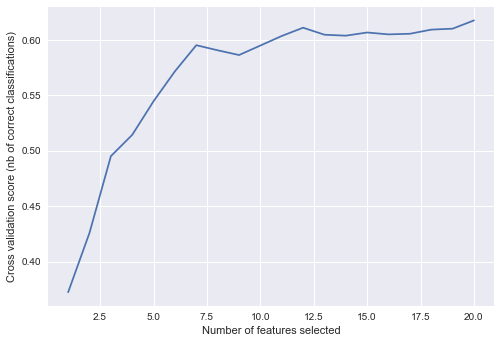

In [43]:
start_set=['f11', 'f12', 'f22', 'f79', 'f82', 'f96', 'f133', 'f138', 'f143', 'f147', 'f152', 'f156', 'f182', 'f187', 'f200', 
           'f76','f185', 'f115', 'f131', 'f83']
estimator = RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X[start_set], y)
print("Optimal number of features : %d" % selector.n_features_)
best_set=list(compress(start_set, selector.support_==1))
print("Optimal set of features : %s" % str(best_set))
print("Optimal CV score : %f" % max(selector.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()


In [44]:
# Считаем модель
scores = cross_val_score(estimator, X[best_set],y,cv=5)
print (scores.mean())

0.617365827137


0.638302938644
